In [2]:
import os
os.getcwd()

'/home/vladislav/Documents/Programming/python_packages/unit-averaging'

In [3]:

import matplotlib.colors as colors
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

from docs.examples.germany_plot_utils import plot_germany
from unit_averaging import InlineFocusFunction, OptimalUnitAverager


In [4]:
german_data = pd.read_csv(
    "docs/examples/data/tutorial_data.csv", parse_dates=True, index_col="period"
)

german_data.index = pd.DatetimeIndex(german_data.index.values, freq="MS")
german_data.iloc[-4:, [0, 2, -1]]

,Aachen - Düren,Ahlen - Münster,Deutschland
2019-09-01,6.2,4.6,4.9
2019-10-01,6.1,4.4,4.8
2019-11-01,6.0,4.5,4.8
2019-12-01,6.1,4.5,4.9


In [5]:
regions = german_data.columns[:-1]
regions


Index(['Aachen - Düren', 'Aalen', 'Ahlen - Münster', 'Annaberg-Buchholz',
       'Ansbach - Weißenburg', 'Aschaffenburg', 'Augsburg', 'Bad Homburg',
       'Bad Kreuznach', 'Bad Oldesloe',
       ...
       'Trier', 'Ulm', 'Weilheim', 'Wesel', 'Wiesbaden', 'Vechta', 'Würzburg',
       'Zwickau', 'Waiblingen', 'Weiden'],
      dtype='object', length=150)

In [6]:
ind_estimates = {}
ind_covar_ests = {}

for region in regions:
    # Extract data and add lags
    ind_data = german_data.loc[:, [region, "Deutschland"]]
    # Run an ARx(1) model
    ar_results = (
        AutoReg(ind_data.loc[:, region], 1, exog=ind_data["Deutschland"])
    ).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    # Add to dictionary
    ind_estimates[region] = ar_results.params.to_numpy()
    ind_covar_ests[region] = ar_results.cov_params().to_numpy()

In [7]:
target_region = "Köln"
target_data = (
    german_data.loc["2019-12", [target_region, "Deutschland"]].to_numpy().squeeze()
)

In [8]:
print(regions.to_numpy())

['Aachen - Düren' 'Aalen' 'Ahlen - Münster' 'Annaberg-Buchholz'
 'Ansbach - Weißenburg' 'Aschaffenburg' 'Augsburg' 'Bad Homburg'
 'Bad Kreuznach' 'Bad Oldesloe' 'Balingen' 'Bamberg - Coburg' 'Bautzen'
 'Bayreuth - Hof' 'Bergisch Gladbach' 'Bad Hersfeld - Fulda'
 'Berlin Mitte' 'Berlin Nord' 'Bielefeld' 'Bochum' 'Bonn'
 'Braunschweig - Goslar' 'Bremen - Bremerhaven' 'Brühl' 'Berlin Süd'
 'Celle' 'Chemnitz' 'Cottbus' 'Darmstadt' 'Deggendorf' 'Detmold'
 'Donauwörth' 'Dortmund' 'Dresden' 'Duisburg' 'Düsseldorf' 'Eberswalde'
 'Elmshorn' 'Coesfeld' 'Emden - Leer' 'Essen' 'Frankfurt'
 'Frankfurt (Oder)' 'Freiberg' 'Freiburg' 'Freising' 'Fürth'
 'Gelsenkirchen' 'Gießen' 'Göppingen' 'Göttingen' 'Greifswald' 'Flensburg'
 'Hamburg' 'Hameln' 'Hamm' 'Hanau' 'Hannover' 'Heide' 'Heidelberg'
 'Heilbronn' 'Helmstedt' 'Herford' 'Hildesheim' 'Hagen' 'Ingolstadt'
 'Iserlohn' 'Kaiserslautern - Pirmasens' 'Karlsruhe - Rastatt' 'Kassel'
 'Kempten - Memmingen' 'Kiel' 'Koblenz - Mayen' 'Köln'
 'Konstanz - Rave

In [9]:
forecast_hamburg = InlineFocusFunction(
    focus_function=lambda coef: coef[0]
    + coef[1] * target_data[0]
    + coef[2] * target_data[1],
    gradient=lambda x: np.array([1, target_data[0], target_data[1]]),
)

In [10]:
forecast_hamburg.focus_function(ind_estimates[target_region])

np.float64(7.589716698045073)

In [11]:
averager = OptimalUnitAverager(
    focus_function=forecast_hamburg,
    ind_estimates=ind_estimates,
    ind_covar_ests=ind_covar_ests,
)

In [12]:
averager.fit(target_id="Hamburg")

In [13]:
averager.weights_
averager.estimate_

np.float64(6.7115905362136035)

In [14]:
averager.weights_[:10].round(3)

array([0.032, 0.002, 0.003, 0.002, 0.001, 0.001, 0.005, 0.005, 0.001,
       0.001])

In [15]:
weight_dict = {}
for key, val in zip(averager.keys, averager.weights_):
    weight_dict[key] = val
    

In [16]:
weight_df = pd.Series(weight_dict).reset_index()
weight_df.columns = ['aab', 'weights']

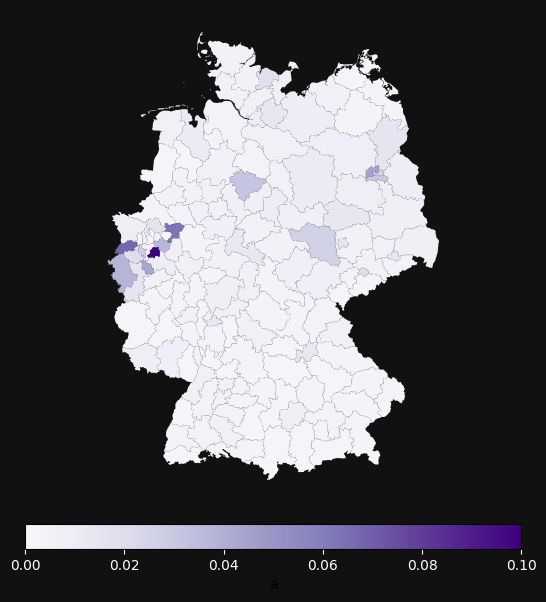

In [17]:
fig, ax = plot_germany(weight_df, cmap='Purples', vmin=-0.005) 